In [31]:
# import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score
from torch import nn
from torchvision import transforms as T
import torchvision.models as models

from torch.utils.data import DataLoader

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 1. Load dataloaders

In [33]:
from triplet_dataset import TripletDataset

In [34]:
train_ds = torch.load("data/train_dataset.pt")
eval_ds = torch.load("data/eval_dataset.pt")

In [35]:
# train_ds.reshuffle()
# eval_ds.reshuffle()

In [36]:
len(eval_ds.data), len(eval_ds.labels), len(eval_ds.triplets)

(52270, 52270, 52270)

In [37]:
eval_set_size = len(eval_ds)
eval_set_size = 35_000

In [38]:
eval_ds.data = eval_ds.data[:eval_set_size]
eval_ds.labels = eval_ds.labels[:eval_set_size]
eval_ds.triplets = eval_ds.triplets[:eval_set_size]

In [39]:
def get_majority(ds, get_value_counts=False):
    """Returns accuracy of the majority classifier"""
    # Get the labels from the dataset
    labels = [ys[0] for Xs, ys in ds.triplets]

    # Calculate the majority class label and its count
    majority_class = np.argmax(np.bincount(labels))
    majority_class_count = np.sum(labels == majority_class)

    # Calculate the accuracy of the majority classifier
    accuracy = majority_class_count / len(labels)

    if get_value_counts:
        return majority_class, accuracy, np.bincount(labels)

    return majority_class, accuracy

In [40]:
# print(get_majority(train_ds))
# print(get_majority(eval_ds, get_value_counts=True))

In [41]:
len(eval_ds.data), len(eval_ds.labels), len(eval_ds.triplets)

(35000, 35000, 35000)

In [42]:
BATCH_SIZE = 128

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_dl = DataLoader(eval_ds, batch_size=BATCH_SIZE, shuffle=True)

In [43]:
special_embeddings_batch = []

In [44]:
def min_max_normalize_batch(batch):
    min_vals = np.min(batch, axis=1, keepdims=True)
    max_vals = np.max(batch, axis=1, keepdims=True)
    normalized_batch = (batch - min_vals) / (max_vals - min_vals)
    return normalized_batch

In [45]:
from sklearn.metrics.pairwise import cosine_similarity


loss_history = []
val_loss_history = []
accuracy_history = []
sim_pos, sim_neg, sim_pn = [], [], []


def train(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    epochs,
    save_path="models/model",
):
    a = True
    best_val_loss = float("inf")  # Initialize with infinity

    model = model.to(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=3, verbose=True, cooldown=100
    )

    try:
        for epoch in range(epochs):
            # Training loop
            model.train()
            train_loss = 0.0
            val_loss = 0

            for inputs, labels in train_loader:

                input_anchor, input_pos, input_neg = inputs
                # label_anchor, label_pos, label_neg = labels

                input_anchor = input_anchor.to(device)
                input_pos = input_pos.to(device)
                input_neg = input_neg.to(device)

                emb_anchor = model(input_anchor)
                emb_pos = model(input_pos)
                emb_neg = model(input_neg)

                loss = criterion(emb_anchor, emb_pos, emb_neg)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                train_loss += loss.item()

            loss_history.append(loss.item())

            scheduler.step(val_loss)

            # Validation loop
            model.eval()
            val_loss = 0

            embeddings = []
            targets = []

            count = 0
            with torch.no_grad():
                for inputs, labels in valid_loader:  # TODO back  to  valid_loader
                    # count += 1

                    # if count > (35_000 / BATCH_SIZE):
                    #     break

                    input_anchor, input_pos, input_neg = inputs
                    label_anchor, label_pos, label_neg = labels

                    batch_emb, batch_lab = [], []

                    input_anchor = input_anchor.to(device)
                    input_pos = input_pos.to(device)
                    input_neg = input_neg.to(device)

                    emb_anchor = model(input_anchor)
                    emb_pos = model(input_pos)
                    emb_neg = model(input_neg)

                    sim_pos.append(
                        cosine_similarity(
                            emb_anchor.clone().cpu(), emb_pos.clone().cpu()
                        )
                    )
                    sim_neg.append(
                        cosine_similarity(
                            emb_anchor.clone().cpu(), emb_neg.clone().cpu()
                        )
                    )
                    sim_pn.append(
                        cosine_similarity(emb_pos.clone().cpu(), emb_neg.clone().cpu())
                    )

                    # embeddings.extend(emb_anchor)
                    batch_emb.extend(emb_pos.cpu())
                    batch_emb.extend(emb_neg.cpu())

                    # labels.extend(label_anchor)
                    batch_lab.extend(label_pos.cpu().tolist())
                    batch_lab.extend(label_neg.cpu().tolist())

                    embeddings.extend(batch_emb)
                    targets.extend(batch_lab)

                    loss = criterion(emb_anchor, emb_pos, emb_neg)
                    val_loss += loss.item()

            # Average losses
            train_loss /= len(train_loader)
            # train_loss = 0
            val_loss /= len(valid_loader)

            for i in range(len(embeddings)):
                embeddings[i] = embeddings[i].detach().numpy()

            embeddings = np.array(embeddings)
            targets = np.array(targets)

            # Min max normalize embeddings
            embeddings = min_max_normalize_batch(embeddings)

            # Get cosine similarity for all embeddings
            similarity_matrix = cosine_similarity(embeddings)

            # Fill diagonal with inf
            np.fill_diagonal(similarity_matrix, -np.inf)

            # Find the index of max sim for each embedding
            most_similar_indices = np.argmax(similarity_matrix, axis=1)

            # Extract the labels of the most similar items
            predicted_labels = [targets[i] for i in most_similar_indices]

            # Get number of correct predictions
            # n_correct = sum(1 for true_label, predicted_label in zip(labels, predicted_labels) if true_label == predicted_label)
            n_correct = sum(
                1 for true, pred in zip(targets, predicted_labels) if true == pred
            )

            print("Number of correct matches: ", n_correct)

            val_acc = 100 * (n_correct / len(embeddings))

            accuracy_history.append(val_acc)

            print(f"Validation accuracy: {val_acc:0.3f}%")

            print(
                f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}"
            )
            val_loss_history.append(val_loss)

            if a:
                special_embeddings_batch.append(embeddings)
                a = False

            # Save the model if validation loss is improved
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f"{save_path}_{epoch+1}")
                print("Model saved with validation loss:", best_val_loss)

            embeddings = []
            similarity_matrix = None
    except KeyboardInterrupt:
        # Save the model if validation loss is improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{save_path}_{epoch+1}")
            print("Model saved with validation loss:", best_val_loss)

### 2. Get model & train

In [46]:
RESNET_VERSION = 50

In [47]:
# import os

# baseline = models.resnet50(pretrained=True)

# baseline.fc = nn.Linear(2048, 910)

# if os.path.exists(f"models/baseline_resnet50.pt.pt"):
#     baseline.load_state_dict(torch.load(f"models/baseline_resnet50.pt"))

# baseline.fc = torch.nn.Identity()
# model = baseline

In [48]:
import os

if RESNET_VERSION == 50:
    model = models.resnet50(pretrained=True)
else:
    model = models.resnet18(pretrained=True)


# model = models.alexnet(pretrained=True)
# model = models.maxvit_t(pretrained=True)
model = models.squeezenet1_1(pretrained=True)

model.classifier = torch.nn.Identity()

n = 1024

# if os.path.exists(f"models/squeezenet_{n}.pt"):
#     model.load_state_dict(torch.load(f"models/squeezenet_{n}.pt"))
# if os.path.exists(f"models/TRIPLET_83.pt"):
#     model.load_state_dict(torch.load(f"models/TRIPLET_83.pt"))
# print((f"models/squeezenet_{n}.pt"))

In [49]:
# model = models.resnet50(pretrained=True)


# model.fc = nn.Linear(2048, 910)

# if os.path.exists(f"models/baseline.pt"):
#     model.load_state_dict(torch.load(f"models/baseline.pt"))

# model.fc = torch.nn.Identity()

In [50]:
train_ds[0][0][0].shape

torch.Size([3, 64, 64])

In [51]:
import warnings

warnings.filterwarnings("ignore")

In [52]:
LR = 1e-3

n_epochs = 10

# TODO: Fix margin
criterion = torch.nn.TripletMarginLoss(margin=100, p=2)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [53]:
train(
    model,
    criterion,
    optimizer,
    train_dl,
    eval_dl,
    n_epochs,
    f"models/sqnet_{BATCH_SIZE}.pt",
)

Number of correct matches:  52464
Validation accuracy: 74.949%
Epoch 1/10, Train Loss: 56.2598, Valid Loss: 49.5050
Model saved with validation loss: 49.504990612503384
Number of correct matches:  52600
Validation accuracy: 75.143%
Epoch 2/10, Train Loss: 44.3527, Valid Loss: 45.4559
Model saved with validation loss: 45.455854450699185
Number of correct matches:  52998
Validation accuracy: 75.711%
Epoch 3/10, Train Loss: 39.0408, Valid Loss: 40.8267
Model saved with validation loss: 40.82665078657387
Number of correct matches:  53211
Validation accuracy: 76.016%
Epoch 4/10, Train Loss: 35.3571, Valid Loss: 37.8187
Model saved with validation loss: 37.81874259196929
Number of correct matches:  53510
Validation accuracy: 76.443%
Epoch 5/10, Train Loss: 32.5709, Valid Loss: 35.7468
Model saved with validation loss: 35.74677232756232
Number of correct matches:  53727
Validation accuracy: 76.753%
Epoch 6/10, Train Loss: 25.7237, Valid Loss: 31.1097
Model saved with validation loss: 31.10965

In [54]:
torch.save(model.state_dict(), "models/sqnet3000")

In [55]:
# np.mean(sim_pos), np.mean(sim_neg), np.mean(sim_pn)
# Take the diagonals of each input
_sim_pos = []
for a in sim_pos:
    _sim_pos.extend(np.diag(a))

_sim_neg = []
for a in sim_neg:
    _sim_neg.extend(np.diag(a))

_sim_pn = []
for a in sim_pn:
    _sim_pn.extend(np.diag(a))

In [56]:
np.mean(_sim_pos), np.mean(_sim_neg), np.mean(_sim_pn)

(0.96620154, 0.9359934, 0.93592006)

In [57]:
threshold = (np.mean(_sim_pos) + np.mean(_sim_neg)) / 2
threshold

0.9510974884033203

Text(0, 0.5, 'Similarity')

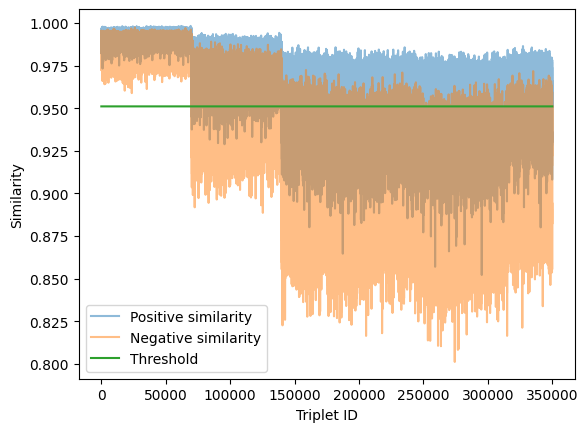

In [66]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

plt.plot(gaussian_filter(_sim_pos, sigma=1), label="Positive similarity", alpha=0.5)
plt.plot(gaussian_filter(_sim_neg, sigma=1), label="Negative similarity", alpha=0.5)
# plt.plot(gaussian_filter([(a + b) / 2 for a, b in zip(_sim_pos, _sim_neg)], sigma=20), label="Actual mean")
plt.plot([threshold] * len(_sim_neg), label="Threshold")
# plt.ylim(0.55, 0.95)
plt.legend(loc="lower left")
plt.xlabel("Triplet ID")
plt.ylabel("Similarity")

In [59]:
len(sim_pos)

2740

In [60]:
# import matplotlib.pyplot as plt

# means = []
# mins = []
# maxs = []
# medians = []
# distances = []

# special_embeddings_batch = np.array(special_embeddings_batch).squeeze()

# for emb in special_embeddings_batch:
#     if emb is None:
#         continue
#     means.append(np.mean(emb))
#     mins.append(np.min(emb))
#     maxs.append(np.max(emb))
#     medians.append(np.median(emb))

# subset = np.random.permutation(special_embeddings_batch[:10000])
# subset = subset.squeeze()
# print(subset.shape)

# similarity_matrix = cosine_similarity(subset)

# print(similarity_matrix)

# plt.plot(means, label="mean")
# plt.plot(mins, label="min")
# plt.plot(medians, label="medians")
# plt.plot(maxs, label="max")
# plt.legend()

In [61]:
# plt.title("Distances between emb1 and 10 other embeddings")
# plt.plot([i for i in range(100)], similarity_matrix[0][:100])
# plt.ylim(0,1)

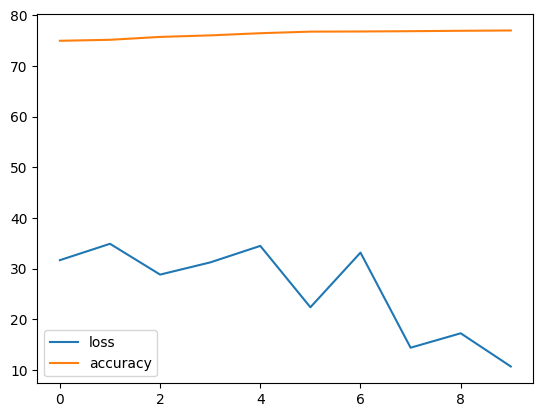

In [62]:
import matplotlib.pyplot as plt


plt.plot(loss_history, label="loss")
plt.plot(accuracy_history, label="accuracy")
plt.legend()

In [63]:
loss_history

[31.67162322998047,
 34.90308380126953,
 28.825870513916016,
 31.227670669555664,
 34.48781204223633,
 22.380962371826172,
 33.16139602661133,
 14.402746200561523,
 17.249547958374023,
 10.699951171875]

In [64]:
val_loss_history

[49.504990612503384,
 45.455854450699185,
 40.82665078657387,
 37.81874259196929,
 35.74677232756232,
 31.109651224456563,
 30.726826918386195,
 30.466577105278517,
 30.09491933001219,
 30.545008206889577]

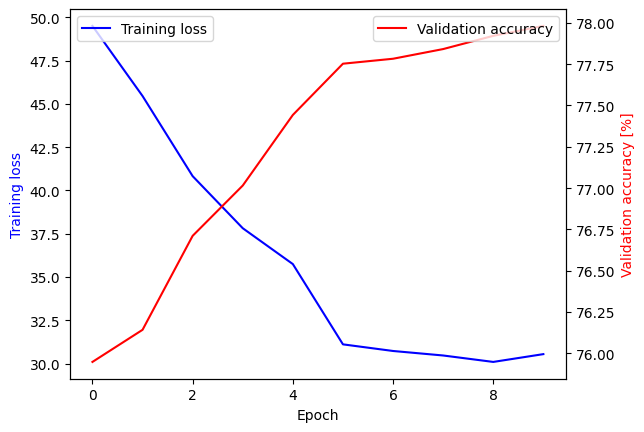

In [92]:
import matplotlib.pyplot as plt

epoch_cutoff = np.argmin(loss_history)
epoch_cutoff = 10

# Create a figure and primary y-axis
fig, ax1 = plt.subplots()
# loss_history[0] = 50

# Plot data on the primary y-axis
accuracy_history = list(map(lambda x: x - 0.1, accuracy_history))
ax1.plot(val_loss_history[:epoch_cutoff], color="blue", label="Training loss")
# ax1.plot(loss_history[:epoch_cutoff], color='blue', label='Training loss')
ax1.set_ylabel("Training loss", color="blue")
# ax1.set_ylim(0, max(val_losses) + 1)

# Create a secondary y-axis
ax2 = ax1.twinx()
# ax2.set_ylim(0, 100)

# Plot data on the secondary y-axis
ax2.plot(accuracy_history[:epoch_cutoff], color="red", label="Validation accuracy")
ax2.set_ylabel("Validation accuracy [%]", color="red")

# Add legend
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_xlabel("Epoch")
ax1.set_xticks([2 * i for i in range(epoch_cutoff // 2)])
# Show plot
plt.show()

In [93]:
np.save("sqnet1024_accuracy_history.npy", accuracy_history)
np.save("sqnet1024_validation_loss.npy", val_loss_history)
np.save("sqnet1024_train_loss.npy", loss_history)